## Исследование данных о российском кинопрокате



Заказчик этого исследования — Министерство культуры Российской Федерации.
Изучим рынок российского кинопроката и выявим текущие тренды.

Уделим внимание фильмам, которые получили государственную поддержку и ответим на вопрос, насколько такие фильмы интересны зрителю.

Будем работать с данными, опубликованными на портале открытых данных Министерства культуры. Набор данных содержит информацию о прокатных удостоверениях, сборах и государственной поддержке фильмов, а также информацию с сайта КиноПоиск. 


### Шаг 1. Загрузка файлов и объединение их в один датафрейм. 

Объединим данные таким образом, чтобы все объекты из датасета `mkrf_movies` обязательно вошли в получившийся датафрейм. 


In [71]:
# импортируем библиотеки
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [72]:
# рассмотрим таблицу с данными о прокате в российских кинотеатрах
df_mkrf_movies=pd.read_csv('/datasets/mkrf_movies.csv')
df_mkrf_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
title                    7486 non-null object
puNumber                 7486 non-null object
show_start_date          7486 non-null object
type                     7486 non-null object
film_studio              7468 non-null object
production_country       7484 non-null object
director                 7477 non-null object
producer                 6918 non-null object
age_restriction          7486 non-null object
refundable_support       332 non-null float64
nonrefundable_support    332 non-null float64
budget                   332 non-null float64
financing_source         332 non-null object
ratings                  6519 non-null object
genres                   6510 non-null object
dtypes: float64(3), object(12)
memory usage: 877.4+ KB


In [73]:
# рассмотрим таблицу с данными о прокатных удостоверениях
df_mkrf_shows=pd.read_csv('/datasets/mkrf_shows.csv')
df_mkrf_shows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3158 entries, 0 to 3157
Data columns (total 2 columns):
puNumber      3158 non-null int64
box_office    3158 non-null float64
dtypes: float64(1), int64(1)
memory usage: 49.5 KB


Прежде чем перейти к обработке колонок объединим данные по колонке puNumber.  

In [74]:
# рассмотрим о обработаем колонку puNumber из таблицы df_mkrf_movies
df_mkrf_movies['puNumber']

0       221048915
1       111013716
2       221038416
3       221026916
4       221030815
          ...    
7481    126008019
7482    121037819
7483    124010819
7484    124010619
7485    124010719
Name: puNumber, Length: 7486, dtype: object

Мы видим, что в колонке имеются числа, однако тип данных заявлен как object, приведём данные к типу int и объединим таблицы в одну БД.

In [75]:
# приводим данные к числовому типу
df_mkrf_movies['puNumber']=pd.to_numeric(df_mkrf_movies['puNumber'], errors='coerce')
# найдём и рассмотрим строки с нулевыми значениями
display(df_mkrf_movies.loc[df_mkrf_movies['puNumber'].isna()==True])
display(df_mkrf_movies['puNumber'].dtype)

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
1797,Курбан-роман. (История с жертвой),NaN,2014-05-15T12:00:00.000Z,Художественный,"ФОНД ""ИННОВАЦИЯ""",Россия,С.Юзеев,М.Галицкая,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN


dtype('float64')

Обработав колонку мы видим, что данные преобразованы к типу float и одно значение определено, как NaN, преобразуем его в 0 и переведём колонку в int

In [76]:
df_mkrf_movies['puNumber'].fillna(0).astype(int)

0       221048915
1       111013716
2       221038416
3       221026916
4       221030815
          ...    
7481    126008019
7482    121037819
7483    124010819
7484    124010619
7485    124010719
Name: puNumber, Length: 7486, dtype: int64

In [77]:
# Объединим таблицы по столбцу puNumber так, 
# чтобы все значения объекты из датасета mkrf_movies обязательно вошли в получившийся датафрейм.
df=df_mkrf_shows.merge(df_mkrf_movies, on='puNumber', how='outer')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7486 entries, 0 to 7485
Data columns (total 16 columns):
puNumber                 7485 non-null float64
box_office               3158 non-null float64
title                    7486 non-null object
show_start_date          7486 non-null object
type                     7486 non-null object
film_studio              7468 non-null object
production_country       7484 non-null object
director                 7477 non-null object
producer                 6918 non-null object
age_restriction          7486 non-null object
refundable_support       332 non-null float64
nonrefundable_support    332 non-null float64
budget                   332 non-null float64
financing_source         332 non-null object
ratings                  6519 non-null object
genres                   6510 non-null object
dtypes: float64(5), object(11)
memory usage: 994.2+ KB


В полученной таблице имеется 16 столбцов и 7486 записей. Перейдём к предобработке данных.

### Шаг 2. Предобработка данных

#### Шаг 2.1. Проверим типы данных

Исходя из предложенного описания таблиц, рассмотрим , какими должны быть типы представленных данных
Таблица mkrf_movies содержит информацию из реестра прокатных удостоверений. У одного фильма может быть несколько прокатных удостоверений.

`title` — название фильма; подходит тип object

`puNumber` — номер прокатного удостоверения; преобразуем в тип int

`show_start_date` — дата премьеры фильма; преобразуем в тип datetime

`type` — тип фильма; подходит тип object

`film_studio` — студия-производитель; подходит тип object

`production_country` — страна-производитель; подходит тип object

`director` — режиссёр; подходит тип object

`producer` — продюсер; подходит тип object

`age_restriction` — возрастная категория; преобразуем в тип int

`refundable_support` — объём возвратных средств государственной поддержки; подходит тип float

`nonrefundable_support` — объём невозвратных средств государственной поддержки; подходит тип float

`financing_source` — источник государственного финансирования; подходит тип object

`budget` — общий бюджет фильма; подходит тип float

`ratings` — рейтинг фильма на КиноПоиске; преобразуем в тип float

`genres` — жанр фильма; подходит тип object

Вывод: будем менять тип колонок `puNumber`, `show_start_date`, `age_restriction`, `ratings`

In [78]:
# изменим тип данных в колонке `puNumber`
df['puNumber'].fillna(0).astype(int)

0       111000113
1       111000115
2       111000116
3       111000117
4       111000118
          ...    
7481    126008019
7482    121037819
7483    124010819
7484    124010619
7485    124010719
Name: puNumber, Length: 7486, dtype: int64

In [79]:
# изменим тип данных в колонке `show_start_date`
df['show_start_date']=pd.to_datetime(df['show_start_date'])
df['show_start_date']

0      2013-01-17 12:00:00+00:00
1      2015-01-14 12:00:00+00:00
2      2016-01-13 12:00:00+00:00
3      2017-01-10 12:00:00+00:00
4      2018-01-23 12:00:00+00:00
                  ...           
7481   2019-12-23 12:00:00+00:00
7482   2019-12-24 12:00:00+00:00
7483   2019-12-28 12:00:00+00:00
7484   2019-12-30 12:00:00+00:00
7485   2019-12-30 12:00:00+00:00
Name: show_start_date, Length: 7486, dtype: datetime64[ns, UTC]

In [80]:
# изменим тип данных в колонке `age_restriction`
df['age_restriction'].value_counts()

«16+» - для детей старше 16 лет           2851
«18+» - запрещено для детей               1605
«12+» - для детей старше 12 лет           1593
«0+» - для любой зрительской аудитории     811
«6+» - для детей старше 6 лет              626
Name: age_restriction, dtype: int64

После более подробного изучения стало понятно, что колонка `age_restriction` заполненв категориальными значениями и производить с ней математические операции в ходе исследования не придётся, значит можно оставить колонку без изменения типа.

In [81]:
#прежде чем преобразовывать колонку к типу float , посмотрим, в каком виде хранятися записи
df['ratings'].unique()

array(['5.1', '6.7', '5.8', '3.2', '5.3', '3.0', '5.4', '6.1', '5.9',
       '4.7', '6.6', '6.0', '7.2', '7.1', '4.5', '7.3', '3.3', '6.8',
       '5.7', nan, '4.9', '4.3', '2.8', '6.2', '3.9', '1.9', '4.8', '7.0',
       '7.5', '6.4', '99%', '4.2', '6.5', '5.2', '5.0', '3.1', '6.3',
       '5.6', '3.7', '2.6', '8.0', '6.9', '7.8', '4.1', '91%', '2.9',
       '7.4', '3.4', '4.6', '7.9', '8.5', '8.1', '98%', '7.6', '94%',
       '1.4', '3.8', '7.7', '1.5', '2.7', '4.4', '4.0', '2.5', '8.3',
       '8.8', '1.2', '8.4', '5.5', '8.2', '8.7', '1.6', '79%', '9.2',
       '1.0', '89%', '90%', '2.1', '28%', '2.4', '3.5', '83%', '64%',
       '8.6', '3.6', '88%', '19%', '97%', '1.1', '62%', '1.3', '1.8',
       '1.7', '9.0', '8.9', '9.1'], dtype=object)

Как видно, некоторые значения записаны в процентах, в процесе преобразования к типу float такие значения могут быть утеряны, поэтому сначала, рассмотрим и обработаем строки с процентным рейтингом.

In [82]:
df.loc[df['ratings'].str.contains('%')==True,'ratings'].count()

29

Таких строк 29, избавимся от знака процента, и переведём значение в баллы.

In [83]:
df['ratings'] = df['ratings'].str.replace(r'\D+', '').fillna(0).astype(int)/10
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7486 entries, 0 to 7485
Data columns (total 16 columns):
puNumber                 7485 non-null float64
box_office               3158 non-null float64
title                    7486 non-null object
show_start_date          7486 non-null datetime64[ns, UTC]
type                     7486 non-null object
film_studio              7468 non-null object
production_country       7484 non-null object
director                 7477 non-null object
producer                 6918 non-null object
age_restriction          7486 non-null object
refundable_support       332 non-null float64
nonrefundable_support    332 non-null float64
budget                   332 non-null float64
financing_source         332 non-null object
ratings                  7486 non-null float64
genres                   6510 non-null object
dtypes: datetime64[ns, UTC](1), float64(6), object(9)
memory usage: 994.2+ KB


#### Шаг 2.2. Изучим пропуски в датафрейме

Изучим по порядку те колонки в которых есть пропуски:

In [84]:
# колонка box_office — сборы в рублях
df['box_office'].describe()

count    3.158000e+03
mean     7.647870e+07
std      2.403531e+08
min      0.000000e+00
25%      8.623900e+04
50%      2.327988e+06
75%      2.397967e+07
max      3.073569e+09
Name: box_office, dtype: float64

Колонка числового типа содержит информацию о сборах фильма в рублях, почти о половине фильмов информации нет, однако они вышли в прокат достаточно давно, и скорее всего какие-то сборы имеют, поэтому неверно было бы заменять пропущенные значения 0, лучше просто оставить без изменений, но при анализе учитывать, что в колонке есть пропущенные значения.

In [85]:
# колонка production_country — страна-производитель имеет две пропущенных строки
df.loc[df['production_country'].isna()==True]

,puNumber,box_office,title,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
64,111001216.0,194527.0,"Детский юмористический киножурнал ""Ералаш. Ну ...",2016-02-09 12:00:00+00:00,Художественный,"ООО ""Продюсерский центр ЕРАЛАШ""",NaN,"Р.Светлов, И.Магитон, А.Арутюнян, Л.Мирский, А...","ООО ""Продюсерский центр ЕРАЛАШ""",«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,7.2,"детский,комедия"
5754,214000410.0,NaN,Мульт личности. Выпуск 5,2010-01-25 12:00:00+00:00,Художественный,NaN,NaN,NaN,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,4.0,"мультфильм,комедия"


In [86]:
# судя по названию, можем определить странну как Россию
df.loc[df['production_country'].isna()==True,'production_country']='Россия'

In [87]:
# колонка film_studio — студия-производитель имеет 18 пропусков
df.loc[df['film_studio'].isna()==True].head()

,puNumber,box_office,title,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
739,111021918.0,41225.0,Доживем до каникул?..,2018-11-15 12:00:00+00:00,Художественный,NaN,Россия,Я.Хальпукова (псевдоним Яна Мартынец),Я.Хальпукова (псевдоним Яна Мартынец),«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,0.0,NaN
4179,121011114.0,NaN,Stars in Shorts,2014-06-03 12:00:00+00:00,Художественный,NaN,"США, Великобритания","Роберт Фестингер, Руперт Френд, Джей Камен, Ни...","Татьяна Келли, Роберта Мунро, Руперт Френд, До...",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.3,комедия
5754,214000410.0,NaN,Мульт личности. Выпуск 5,2010-01-25 12:00:00+00:00,Художественный,NaN,Россия,NaN,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,4.0,"мультфильм,комедия"
6824,111013818.0,NaN,Значит любит,2018-08-10 12:00:00+00:00,Художественный,NaN,Россия,А.Краевский,Е.Щербакова,«18+» - запрещено для детей,NaN,NaN,NaN,NaN,0.0,NaN
6863,112007018.0,NaN,Несейка. Младшая дочь,2018-09-01 12:00:00+00:00,Документальный,NaN,Россия,В.Марин,"Д.Якунин, Ф.Абрютин, О.Филонова",«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,0.0,NaN


Можно восстановить значения, пользуясь ресурсами сети Интернет, но поскольку данная колонка не используется в анализе, оставим данные без изменений.

In [88]:
# колонка director — режиссёр имеет 9 пропусков, рассмотрим их
df.loc[df['director'].isna()==True]

,puNumber,box_office,title,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
3040,126003512.0,44350.0,"Три звезды. Концерт в Waldbuhne Theater, Берли...",2012-12-04 12:00:00+00:00,Прочие,Райзинг Алтернатив,Великобритания,NaN,Вальдбюне Театр,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,0.0,NaN
4490,126003413.0,NaN,Помпеи. Британский музей,2013-09-11 12:00:00+00:00,Прочие,"МортуСкрин, Британский музей",Великобритания,NaN,Британский музей,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,0.0,NaN
5225,217027010.0,NaN,Зур концерт (Большой концерт).,2010-06-24 12:00:00+00:00,Художественный,"ООО ""Барс Рекордс""",Россия,NaN,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,0.0,NaN
5414,217017310.0,NaN,"Ганс Сэйфуллин ""Авылым чишмэлэре. Ганс Сэйфулл...",2010-04-22 12:00:00+00:00,Художественный,"ООО ""Барс-Рекордс""",Россия,NaN,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,0.0,NaN
5632,217020610.0,NaN,Изге Вэли (Святой Валентин),2010-05-20 12:00:00+00:00,Художественный,"ООО ""Барс Рекордс""",Россия,NaN,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,0.0,NaN
5732,126001710.0,NaN,Bon Jovi. The Circle Tour,2010-11-11 12:00:00+00:00,Прочие,Эншутц Интертейнмент Груп,США,NaN,Эншутц Интертейнмент Груп,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,7.9,"концерт,музыка"
5754,214000410.0,NaN,Мульт личности. Выпуск 5,2010-01-25 12:00:00+00:00,Художественный,NaN,Россия,NaN,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,4.0,"мультфильм,комедия"
6189,126001111.0,NaN,Георг Фридрих Гендель. Мессия. Оратория. Корол...,2011-04-25 12:00:00+00:00,Прочие,Опус Арт,Великобритания,NaN,Короевский колледж Кембриджа,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,0.0,NaN
6206,126002711.0,NaN,Питер Гэбриэл и New Blood Orchestra 3D,2011-11-11 12:00:00+00:00,Прочие,Омниверс Визион,Великобритания,NaN,Омниверс Визион,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,6.7,"концерт,музыка"


После изучения фрагмента видим, что эти 9 записей содержат информацию не о фильмах, а о записях концертов или экскурсия, 9 записей составляют 0.001 часть процента, можем их удалить.

In [89]:
df=df.loc[df['director'].isna()==False]

In [90]:
# колонка producer — продюсер имеет 564 пропуска
df.loc[df['producer'].isna()==True]

,puNumber,box_office,title,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
46,111000915.0,197464.5,Горе от ума.,2015-02-05 12:00:00+00:00,Художественный,Киностудия им. М.Горького,СССР,"С.Алексеев, В.Войтецкий",NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.0,драма
113,111002216.0,240.0,Мама _,2016-02-12 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм"", Киностудия ""Букурешти"",...","СССР, Румыния, Франция",Э.Бостан,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,7.1,"ужасы,драма,триллер"
140,111002915.0,249166767.7,А зори здесь тихие..._,2015-03-16 12:00:00+00:00,Художественный,"ООО ""Компания ""Реал-Дакота""",Россия,Р.Давлетьяров,NaN,«12+» - для детей старше 12 лет,50000000.0,100000000.0,220588394.0,Фонд кино,8.5,"драма,военный,история"
148,111003116.0,1900.0,Не может быть!,2016-02-12 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,Л.Гайдай,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,8.1,"мелодрама,комедия"
164,111003616.0,360.0,Неподдающиеся,2016-02-12 12:00:00+00:00,Художественный,"Киностудия ""Мосфильм""",СССР,Ю.Чулюкин,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,8.0,"мелодрама,комедия"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7435,111020419.0,NaN,Отряд специального назначения,2019-12-01 12:00:00+00:00,Художественный,Свердловская киностудия,СССР,Г.Кузнецов,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,7.0,"приключения,военный"
7436,111020519.0,NaN,Назначаешься внучкой,2019-12-01 12:00:00+00:00,Художественный,Свердловская киностудия,СССР,Я.Лапшин,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,7.0,военный
7437,111020619.0,NaN,Перед рассветом,2019-12-01 12:00:00+00:00,Художественный,Свердловская киностудия,СССР,Я.Лапшин,NaN,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.9,"драма,мелодрама"
7438,111020719.0,NaN,Ты помнишь,2019-12-01 12:00:00+00:00,Художественный,Свердловская киностудия,СССР,О.Николаевский,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,7.0,"драма,мелодрама,военный"


В осовном запись о продюссере пропущена для фильмов, выпущенных в СССР, фильмы выпускались по заказу государства и такого понятия как продюссирование не существовало. Не стоит удалять эти записи, т.к. их достаточно много и результат исследования может исказиться, кроме того колонка с информацией о продюссере непосредственно в исследовании не участвует. 

In [91]:
# колонка genres — жанр фильма имеет 970 пропусков
df['genres'].value_counts()

драма                              476
комедия                            352
мелодрама,комедия                  222
драма,мелодрама,комедия            189
драма,мелодрама                    183
                                  ... 
триллер,драма,боевик                 1
документальный,фэнтези               1
реальное ТВ                          1
фантастика,приключения,детектив      1
триллер,криминал,приключения         1
Name: genres, Length: 742, dtype: int64

Столбец содеожит категориальные значения, заполнить пропуски нет возможности, удалять их нелься, т. к. их более 10 процентов, оставим пропущенные строки и будем учитывать это при анализе данных.

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7477 entries, 0 to 7485
Data columns (total 16 columns):
puNumber                 7476 non-null float64
box_office               3157 non-null float64
title                    7477 non-null object
show_start_date          7477 non-null datetime64[ns, UTC]
type                     7477 non-null object
film_studio              7460 non-null object
production_country       7477 non-null object
director                 7477 non-null object
producer                 6913 non-null object
age_restriction          7477 non-null object
refundable_support       332 non-null float64
nonrefundable_support    332 non-null float64
budget                   332 non-null float64
financing_source         332 non-null object
ratings                  7477 non-null float64
genres                   6507 non-null object
dtypes: datetime64[ns, UTC](1), float64(6), object(9)
memory usage: 993.0+ KB


In [93]:
# рассмтрим полонки `refundable_support`, `nonrefundable_support`, `budget`, `financing_source`
# и убедимся в том, что речь идет про одни и теже 332 ненулевые колонки
df.loc[(df['refundable_support'].isna()==False)&(df['nonrefundable_support'].isna()==False)&(df['budget'].isna()==False)&(df['financing_source'].isna()==False)].count()

puNumber                 332
box_office               318
title                    332
show_start_date          332
type                     332
film_studio              332
production_country       332
director                 332
producer                 330
age_restriction          332
refundable_support       332
nonrefundable_support    332
budget                   332
financing_source         332
ratings                  332
genres                   316
dtype: int64

Как видно из среза с условием, действительно имеется 332 записи для которых представлена информация об объёме возвретных и невозвратных денежных средств, бюджете и источнике финансирования. Мы сможем пользоваться этими записями для анализа. Остальные удалять разумеется не будем, т. к. незаполненные такими данными записи составляют большую часть базы данных, их нельзя удалять.

#### Шаг 2.3. Изучим дубликаты в датафрейме

In [94]:
# сначала проверим имеются ли записи являющиеся полными дубликатами
df.loc[df.duplicated()==True].count()

puNumber                 0
box_office               0
title                    0
show_start_date          0
type                     0
film_studio              0
production_country       0
director                 0
producer                 0
age_restriction          0
refundable_support       0
nonrefundable_support    0
budget                   0
financing_source         0
ratings                  0
genres                   0
dtype: int64

Таких записей нет.

Учитывая специфику базы данных, рассмотрим имеются ли дубликаты в основной колонке `title`

In [95]:
df.loc[df['title'].duplicated()==True].count()

puNumber                 714
box_office                30
title                    714
show_start_date          714
type                     714
film_studio              713
production_country       714
director                 714
producer                 703
age_restriction          714
refundable_support         1
nonrefundable_support      1
budget                     1
financing_source           1
ratings                  714
genres                   705
dtype: int64

Имеется 714 дубликатов, но проверялось совпадение только в колонке название, возможно у фильмов разные режиссёры или год выхода в российский прокат, добавим колонки для поиска, пользуясь возможностями метода duplicated

In [96]:
df.loc[df.duplicated(subset=['title','show_start_date','film_studio'],keep=False)==True]

,puNumber,box_office,title,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
1017,121002316.0,332371.0,Анархисты,2016-02-03 12:00:00+00:00,Художественный,"24 Май Продюксьон, Франс 2 Синема",Франция,Эли Важеман,Лола Гэнс,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,5.7,драма
1203,121005715.0,52495.0,Последние пять лет.,2015-03-25 12:00:00+00:00,Художественный,"Гранд Пикс Интертейнмент, Лаки Манки Пикчерз, ...",США,Ричард ЛаГравенес,"Джанет Бреннер, Лорен Версель, Курт Дойтч, Рич...",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,5.7,"мюзикл,драма,мелодрама"
2730,124001915.0,14152495.9,Пингвиненок Пороро: Большие гонки,2015-04-15 12:00:00+00:00,Анимационный,"Окон Студиос, Чина Филм, Симка Интертейнмент, ...",Южная Корея - КНР,Юнг Куюн Парк,"Иль Хо Ким, Михал Симка",«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,5.2,"мультфильм,семейный,спорт"
3147,224001915.0,1360.0,Пингвиненок Пороро: Большие гонки,2015-04-15 12:00:00+00:00,Анимационный,"Окон Студиос, Чина Филм, Симка Интертейнмент, ...",Южная Корея - КНР,Юнг Куюн Парк,"Иль Хо Ким, Михал Симка",«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,5.2,"мультфильм,семейный,спорт"
4184,121025713.0,NaN,Эпидемия_,2013-10-07 12:00:00+00:00,Художественный,"Морена Фильм, Ребелион Террестр, А 3 Медиа Гру...",Испания - Франция,"Алекс Пастор, Давид Пастор","Мерседес Гамеро, Альберто Марини, Педро Уриоль",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.2,"драма,фантастика,триллер"
4185,221035513.0,NaN,Эпидемия_,2013-10-07 12:00:00+00:00,Художественный,"Морена Фильм, Ребелион Террестр, А 3 Медиа Гру...",Испания - Франция,"Алекс Пастор, Давид Пастор","Мерседес Гамеро, Альберто Марини, Педро Уриоль",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.2,"драма,фантастика,триллер"
4307,121006514.0,NaN,Оторвы,2014-04-07 12:00:00+00:00,Художественный,"Проминент Пикчерз, Ворлдвью Интертейнмент, Инд...",США,Кристофер Нельсон,"Молли Коннерс, Хезер Рэй",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,3.5,"комедия,приключения"
4308,221013214.0,NaN,Оторвы,2014-04-07 12:00:00+00:00,Художественный,"Проминент Пикчерз, Ворлдвью Интертейнмент, Инд...",США,Кристофер Нельсон,"Молли Коннерс, Хезер Рэй",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,3.5,"комедия,приключения"
4725,221008115.0,NaN,Последние пять лет.,2015-03-25 12:00:00+00:00,Художественный,"Гранд Пикс Интертейнмент, Лаки Манки Пикчерз, ...",США,Ричард ЛаГравенес,"Джанет Бреннер, Лорен Версель, Курт Дойтч, Рич...",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,5.7,"мюзикл,драма,мелодрама"
5034,221003916.0,NaN,Анархисты,2016-02-03 12:00:00+00:00,Художественный,"24 Май Продюксьон, Франс 2 Синема",Франция,Эли Важеман,Лола Гэнс,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,5.7,драма


Как видно из таблицы, нашлось 8 дубликатов, из одинакового названия, даты выхода в прокат и студии становится ясно, что в данном случае речь идет про одни и те же фильмы, несмотря на то, что у них не совпадают номера прокатных удостоверений, несовпадение может быть связано с тем, что прокатное удостоверение на один и тот же фильм выдано двум разным "лицам,  имеющим «неисключительную лицензию».

Удалим эти дубликаты, т. к. они не повлияют на дальнейшее исследование.

<div class="alert alert-block alert-success">
<b>Success:</b> очень хорошо! Здорово, что глубоко копаешь в тему и разбираешься в контексте

In [97]:
df=df.drop_duplicates(subset=['title','show_start_date','film_studio'],keep='first')

Теперь из датафрейма удалены дубликаты фильмов, оставлены только первые вхождения.

#### Шаг 2.4. Изучим категориальные значения

- Посмотрим, какая общая проблема встречается почти во всех категориальных столбцах;
- Исправим проблемные значения в поле `type`.


Рассмотрим подробнее данные из категориальных столбцов:`type`, `production_country`, `age_restriction`, `genres`.

In [98]:
# рассмотрим столбец `type`
df['type'].value_counts()

Художественный                4512
 Художественный               1388
Анимационный                   826
Прочие                         401
Документальный                 287
Научно-популярный               53
Музыкально-развлекательный       1
 Анимационный                    1
Name: type, dtype: int64

In [99]:
# В начале некоторых строк имеются пробелы, удалим их и роверим результат
df['type']=df['type'].str.strip()
df['type'].value_counts()

Художественный                5900
Анимационный                   827
Прочие                         401
Документальный                 287
Научно-популярный               53
Музыкально-развлекательный       1
Name: type, dtype: int64

In [100]:
# рассмотрим столбец `production_country` 
df['production_country']=df['production_country'].str.strip() # удаляем лишние пробелы
df['production_country'].value_counts()

США                                 2172
Россия                              1817
СССР                                 377
Франция                              301
Великобритания                       255
                                    ... 
Канада-Великобритания                  1
Норвегия, Швеция, Дания                1
Германия - Нидерланды - ЮАР            1
Великобритания, Франция, Бельгия       1
США, Канада                            1
Name: production_country, Length: 934, dtype: int64

В данном случае следует оставить категориальные значения как есть, но если бы исследование требовало более углублённого анализа стран-производителей фильмов, то возможно было бы правильнее завести отдельную таблицу в названиями колонок - странами произодителями `russia`, `usa` и т. д. и придать им булев тип. И связать эту таблицу с основной через полу индекса.

In [101]:
# рассмотрим колонку `age_restriction`
df['age_restriction'].value_counts()

«16+» - для детей старше 16 лет           2845
«18+» - запрещено для детей               1605
«12+» - для детей старше 12 лет           1590
«0+» - для любой зрительской аудитории     803
«6+» - для детей старше 6 лет              626
Name: age_restriction, dtype: int64

Эта колонка содержит категории в порядке, в поправках не нуждается.

In [102]:
# рассмотрим колонку `genres`
df['genres']=df['genres'].str.strip() # удаляем лишние пробелы
df['genres'].value_counts()

драма                              475
комедия                            352
мелодрама,комедия                  222
драма,мелодрама,комедия            189
драма,мелодрама                    183
                                  ... 
документальный,фэнтези               1
фантастика,приключения,детектив      1
комедия,приключения,история          1
комедия,мелодрама,криминал           1
триллер,криминал,приключения         1
Name: genres, Length: 742, dtype: int64

В данном случае, учитывая, что мы в основном рассматриваем жанровое кино, будет ошибочно например лемматизировать эту колонку, т. к. по данным  портала IMDb ( Internet Movie Database ) один и тот же фильм действительно может сочетать в себе несколько разных жанров, неправильно было бы лишать некоторые фильмы части описания.

#### Шаг 2.5. Проверим количественные значения

- Проверим, обнаружились ли в таких столбцах подозрительные данные.


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7469 entries, 0 to 7485
Data columns (total 16 columns):
puNumber                 7468 non-null float64
box_office               3156 non-null float64
title                    7469 non-null object
show_start_date          7469 non-null datetime64[ns, UTC]
type                     7469 non-null object
film_studio              7453 non-null object
production_country       7469 non-null object
director                 7469 non-null object
producer                 6905 non-null object
age_restriction          7469 non-null object
refundable_support       332 non-null float64
nonrefundable_support    332 non-null float64
budget                   332 non-null float64
financing_source         332 non-null object
ratings                  7469 non-null float64
genres                   6500 non-null object
dtypes: datetime64[ns, UTC](1), float64(6), object(9)
memory usage: 992.0+ KB


Проверим количественные колонки `refundable_support`, `nonrefundable_support`, `budget`, `box_office`.  В рамках поддержки от Фонда кино (для игрового кино) или от Министерства культуры (документальное, детское, авторское и т. д.) выделяются как возвратные, так и безвозвратные средства, составляющие бюджет фильма, следовательно, если сложить значение в колонках `refundable_support` и `nonrefundable_support`, то должно получиться значение, не превышающее `budget`, проверим это.

In [104]:
df.loc[df['refundable_support']+df['nonrefundable_support']>df['budget'],'budget'].count()

17

Имеется 17 таких фильмов, рассмотрим подробнее эти значения.

In [105]:
df.loc[df['refundable_support']+df['nonrefundable_support']>df['budget']]

,puNumber,box_office,title,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
16,111000415.0,4.461635e+08,Дуxless 2,2015-01-26 12:00:00+00:00,Художественный,"ООО ""Киностудия ""Слово"", ООО ""Арт Пикчерс Студия""",Россия,Р.Прыгунов,"П.Ануров, Ф.Бондарчук, Д.Рудовский",«16+» - для детей старше 16 лет,0.0,75000000.0,0.0,Фонд кино,6.6,драма
196,111004317.0,5.045195e+07,Мифы,2017-06-07 12:00:00+00:00,Художественный,"ООО ""ХАЙПФИЛМ"", ООО ""Арт Пикчерс Студия""",Россия,А.Молочников,"Ф.Бондарчук, Д.Рудовский, И.Стюарт, М.Османн, ...",«16+» - для детей старше 16 лет,25000000.0,20000000.0,0.0,Фонд кино,4.8,комедия
234,111004916.0,1.536293e+07,Помню - не помню!,2016-03-01 12:00:00+00:00,Художественный,"ООО ""КиноФирма""",Россия,В.Ровенский,"ООО ""КиноФирма""",«12+» - для детей старше 12 лет,0.0,6000000.0,0.0,Министерство культуры,4.3,комедия
392,111008216.0,7.029905e+07,Любовь с ограничениями,2016-04-29 12:00:00+00:00,Художественный,"АО ""ВайТ Медиа"", ООО ""Арт Пикчерс Студия""",Россия,Д.Тюрин,"Ф.Бондарчук, Т.Вайнштейн, Д.Рудовский",«16+» - для детей старше 16 лет,19000000.0,51000000.0,0.0,Фонд кино,6.3,"комедия,мелодрама"
454,111009615.0,6.741897e+07,Бармен.,2015-05-26 12:00:00+00:00,Художественный,"АО ""ВайТ Медиа"", ООО ""Арт Пикчерс Студия""",Россия,Д.Штурманова,Т.Вайнштейн,«16+» - для детей старше 16 лет,20000000.0,0.0,0.0,Фонд кино,6.2,"комедия,фэнтези"
482,111010215.0,1.957739e+06,Тряпичный союз,2015-06-08 12:00:00+00:00,Художественный,"ООО ""Кинокомпания ""КОКТЕБЕЛЬ""",Россия,М.Местецкий,"Р.Борисевич, А.Кушаев",«18+» - запрещено для детей,0.0,59000000.0,0.0,Фонд кино,6.3,"комедия,драма"
543,111012117.0,2.251964e+08,Селфи,2018-02-01 12:00:00+00:00,Художественный,"ООО ""Киностудия ""Слово"", ООО ""Арт Пикчерс Студия""",Россия,Н.Хомерики,"П.Ануров, Ф.Бондарчук, Д.Рудовский",«16+» - для детей старше 16 лет,20000000.0,40000000.0,0.0,Фонд кино,5.8,"триллер,драма"
653,111017115.0,7.293778e+07,Срочно выйду замуж,2015-09-30 12:00:00+00:00,Художественный,"АО ""ВайТ Медиа"", ООО ""Арт Пикчерс Студия""",Россия,С Чекалов,"Ф.Бондарчук, Т.Вайнштейн, Д.Рудовский",«16+» - для детей старше 16 лет,0.0,35000000.0,0.0,Фонд кино,5.1,"комедия,мелодрама"
658,111017315.0,1.965724e+08,Воин (2015),2015-09-28 12:00:00+00:00,Художественный,"ООО ""Форпост Продакшн"", ООО ""Арт Пикчерс Студия""",Россия,А.Андрианов,"ООО ""Арт Пикчерс Студия""",«12+» - для детей старше 12 лет,10000000.0,70000000.0,0.0,Фонд кино,7.8,"боевик,драма,криминал"
676,111018116.0,1.038321e+09,Притяжение (2016),2016-12-16 12:00:00+00:00,Художественный,"ООО ""Водород 2011"", ООО ""Арт Пикчерс Студия""",Россия,Ф.Бондарчук,"ООО ""Арт Пикчерс Студия""",«12+» - для детей старше 12 лет,0.0,250000000.0,0.0,Фонд кино,5.6,фантастика


Как видно из фрагмента таблицы, имеется 17 записей, у которых в колонке бюджет фильма указан 0, поэтому колонку в данном случае колонку можно обработать таким образом , сложить объём возвратных и невозвратных стредств и сумму внести в колонку `budget`

In [106]:
df.loc[df['refundable_support']+df['nonrefundable_support']>df['budget'], 'budget']=df['refundable_support']+df['nonrefundable_support']

#### Шаг 2.6. Добавим новые столбцы





- Создадим столбец с информацией о годе проката. Выделим год из даты премьеры фильма.

In [107]:
# создадим столбец с годом прогката фильма
df['year_release']=df['show_start_date'].dt.year

- Создадим два столбца: с именем и фамилией главного режиссёра и основным жанром фильма. В столбцы войдут первые значения из списка режиссёров и жанров соответственно.

In [108]:
def first_word(string):# передаём в функцию запись из каждой строки серии
    word=string.split(",")# разрезаем строку на список с разделителем ","
    return (word[0])# возвращаем нулевой элемент списка
df['main_director']=df['director'].apply(first_word) # применяем функцию к каждой записи серии
df['main_genre']=df['genres'].astype(str).apply(first_word)
df[['director','main_director','genres','main_genre']].head()# провряем, что получилось

,director,main_director,genres,main_genre
0,Ренни Харлин,Ренни Харлин,"ужасы,фантастика",ужасы
1,Ю.Фетинг,Ю.Фетинг,"детский,семейный",детский
2,П.Руминов,П.Руминов,"комедия,мелодрама",комедия
3,А.Матисон,А.Матисон,драма,драма
4,"З.Болотаев, К.Смирнов",З.Болотаев,комедия,комедия


- Посчитайте, какую долю от общего бюджета фильма составляет государственная поддержка.

Средняя доля составляет 0.5420979916491464


Text(0.5, 0, 'Доля')

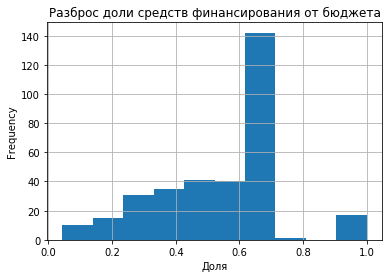

In [109]:
df['share_of_budget']=0 # создаём новую колонку
# в следующей длинной строке заполняем колонку долями для непустых значений
df.loc[(df['refundable_support'].isna()==False)&(df['nonrefundable_support'].isna()==False)&(df['budget'].isna()==False)&(df['financing_source'].isna()==False)&(df['budget']!=0),'share_of_budget']=(df['nonrefundable_support']+df['refundable_support'])/df['budget']
# рассчитываем среднюю долю
print('Средняя доля составляет',df.loc[df['share_of_budget']!=0,'share_of_budget'].mean())
# смотрим на разброс
df.loc[df['share_of_budget']!=0,'share_of_budget'].plot(kind='hist',bins=10,grid=True,title='Разброс доли средств финансирования от бюджета').set_xlabel('Доля')

Как видно, у большей части фильмов доля государственного финансирования составляет более 0,6

### Шаг 3. Проведем исследовательский анализ данных


- Посмотрим, сколько фильмов выходило в прокат каждый год. Обратм внимание, что данные о прокате в кинотеатрах известны не для всех фильмов. Посчитаем, какую долю составляют фильмы с указанной информацией о прокате в кинотеатрах.

year_release,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
title,979,620,592,628,806,703,817,505,889,930


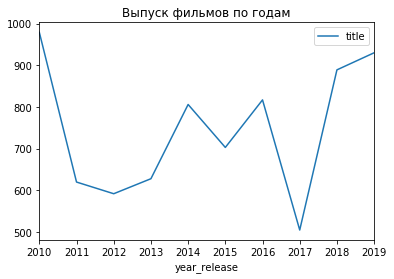

In [110]:
display(df.pivot_table(columns='year_release',values='title',aggfunc='count'))
display(df.pivot_table(index='year_release',values='title',aggfunc='count').plot(title='Выпуск фильмов по годам'))

Как видно из графика, наибольшее количество фильмов было выпущено в 2010 году, а наименьшее в 2017.

- С помощью сводной таблицы посчитаем среднюю и медианную сумму сборов для каждого года.

In [111]:
# посчитаем среднюю сумму сборов (в миллионах)
df['box_office_mln']=(df['box_office']/1000000) # переведём в миллионы
print('Средняя сумма сборов по годам')
display(df.loc[df['box_office_mln'].isna()==False]\
        .pivot_table(index='year_release',values='box_office_mln',aggfunc=['mean','median'])\
        .style.highlight_max (color = '#952895'). highlight_min (color = '#F09EF0'))

Средняя сумма сборов по годам


,mean,median
,box_office_mln,box_office_mln
year_release,,
2010,0.02313,0.0017
2011,0.129383,0.003
2012,0.0544179,0.00556
2013,0.161955,0.0035225
2014,26.6844,0.01816
2015,85.1236,4.94675
2016,91.0006,3.84668
2017,136.033,9.96834


Не смотря на то, что в 2010 году сняли наибольшее количество фильмов, прокат этих фильмов собрал наименьшую сумму, а 2017 году, наибольшую, хотя было снято наименьшее число фильмов.

- Определим, влияет ли возрастное ограничение аудитории («6+», «12+», «16+», «18+» и т. д.) на сборы фильма в прокате в период с 2015 по 2019 год. Выясним, фильмы с каким возрастным ограничением собрали больше всего денег в прокате; меняется ли картина в зависимости от года (попробуем предположить,  с чем это может быть связано).

Text(0.5, 1, 'Связь возрастных ограничений со сборами фильма')

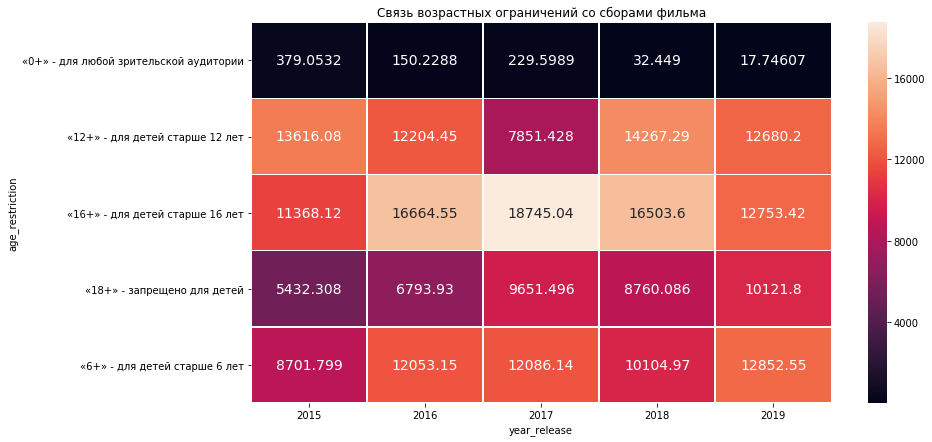

In [112]:
# изучим связь возрастных ограничений и сборов фильма в прокате

plt.figure(figsize=(13, 7))


df_from_heatmap=df.loc[df['year_release']>=2015]\
.pivot_table(index='age_restriction',columns='year_release',values='box_office_mln',aggfunc='sum')

sns.heatmap(df_from_heatmap,
            linewidths=0.5,
            annot_kws={'fontsize':14},
            fmt='.7g',
            square=False,
            annot=True).set_title('Связь возрастных ограничений со сборами фильма')


Как видно из хитмепа, меньше всего собирают фильмы с возрастным ограничением 0+ (возможно одна из причин  - это льготные билеты, в этой категории как правило снимаются мультфильмы и детские фильмы, зрительская аудитория в возрасте до 6 лет и школьники чаще всего имеют льготы на покупку билетов)
Также можно предположить, что категория 16+ - наиболее выгодная с точки зрения сборов фильма (учащиеся старших классов), следующая возрастная категримя - 18+ - студенты и взрослые которые , судя по хитмепу, более неохотно покупают билеты в кино.

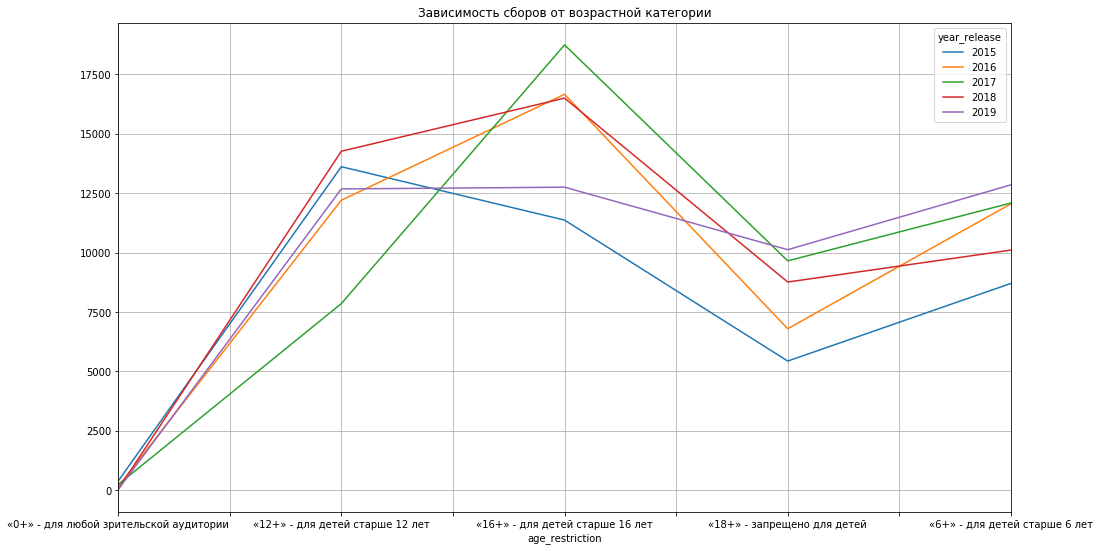

In [113]:
# рассмотрим зависимость сборов от возрастной категории на графике
#plt.figure(figsize=(25,15))
df.loc[df['year_release']>=2015]\
.pivot_table(index='age_restriction',columns='year_release',values='box_office_mln',aggfunc='sum').plot(
    grid=True,
    title='Зависимость сборов от возрастной категории',
    figsize=(16,9)
)

Судя по сборам, в прокате лидируют фильмы с возрастным ограничением 16+, исключение составляет 2015 год, возможно, следует изучить вышедшие в 2017 году фильмы и изменения в рекомендациях возрастных ограничесний, принятые в 2015-2017 году. 

In [114]:
df.loc[df['year_release']==2017].sort_values(by='box_office',ascending=False).head()

,puNumber,box_office,title,show_start_date,type,film_studio,production_country,director,producer,age_restriction,...,nonrefundable_support,budget,financing_source,ratings,genres,year_release,main_director,main_genre,share_of_budget,box_office_mln
533,111011817.0,2.779686e+09,Движение вверх,2017-12-21 12:00:00+00:00,Художественный,"ООО ""Студия ""ТРИТЭ"" Никиты Михалкова""",Россия,А.Мегердичев,"Л.Верещагин, А.Златопольский, Н.Михалков, ООО ...",«6+» - для детей старше 6 лет,...,400000000.0,590192191.0,Фонд кино,7.5,"спорт,драма",2017,А.Мегердичев,спорт,0.677745,2779.686144
1377,121009217.0,2.118396e+09,Пираты Карибского моря: Мертвецы не рассказыва...,2017-05-17 12:00:00+00:00,Художественный,"Джерри Брукхаймер Филмз, Уолт Дисней Пикчерз, ...",США,"Йоаким Реннинг, Эспен Сандберг",Джерри Брукхаймер,«16+» - для детей старше 16 лет,...,NaN,NaN,NaN,6.6,"фэнтези,боевик,комедия",2017,Йоаким Реннинг,фэнтези,0.000000,2118.396119
336,111007017.0,1.655038e+09,Последний богатырь,2017-10-19 12:00:00+00:00,Художественный,"ООО ""Киностудия ""Слово"" по заказу ООО ""Уолт Ди...",Россия,Д.Дьяченко,"Э.Илоян, Д.Жалинский, М.Озкан, А.Троцюк, В.Шляппо",«12+» - для детей старше 12 лет,...,50000000.0,352477575.0,Фонд кино,6.8,"комедия,фэнтези,приключения",2017,Д.Дьяченко,комедия,0.283706,1655.037688
1325,121008117.0,1.468780e+09,Стражи Галактики. Часть 2,2017-04-27 12:00:00+00:00,Художественный,"Марвел Студиос, Уолт Дисней Пикчерз",США,Джеймс Ганн,Кевин Фейги,«16+» - для детей старше 16 лет,...,NaN,NaN,NaN,7.6,"фантастика,боевик,приключения",2017,Джеймс Ганн,фантастика,0.000000,1468.779681
1199,121005617.0,1.429977e+09,Форсаж 8,2017-04-03 12:00:00+00:00,Художественный,"Итака Филмз, Уан Рейс Филмз, Ориджинал Фильм",США,Ф.Гэри Грей,"Вин Дизель, Нил Х.Мориц, Майкл Фоттрел",«12+» - для детей старше 12 лет,...,NaN,NaN,NaN,6.2,"боевик,триллер,криминал",2017,Ф.Гэри Грей,боевик,0.000000,1429.976813


### Шаг 4. Исследуем фильмы, которые получили государственную поддержку

Исследуем фильмы, которые получили государственную поддержку, для этого все фильмы, для которых есть данные о размерах государственной поддержки мы поместим в отдельную таблицу.

In [115]:
df_gov_sup=df.loc[(df['refundable_support'].isna()==False)&(df['nonrefundable_support'].isna()==False)&(df['budget'].isna()==False)&(df['financing_source'].isna()==False)]
df_gov_sup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332 entries, 1 to 7479
Data columns (total 21 columns):
puNumber                 332 non-null float64
box_office               318 non-null float64
title                    332 non-null object
show_start_date          332 non-null datetime64[ns, UTC]
type                     332 non-null object
film_studio              332 non-null object
production_country       332 non-null object
director                 332 non-null object
producer                 330 non-null object
age_restriction          332 non-null object
refundable_support       332 non-null float64
nonrefundable_support    332 non-null float64
budget                   332 non-null float64
financing_source         332 non-null object
ratings                  332 non-null float64
genres                   316 non-null object
year_release             332 non-null int64
main_director            332 non-null object
main_genre               332 non-null object
share_of_budget      

Изучим данные и рассмотрим:

1) Какую часть фильмов финансирует Фонд кино, а какую Министерство культуры

2) Какие фильмы приносят больше сборов, иговые (Фонд кино) или документальные , детские и т. д. (Министерство культуры)

3) Какие фильмы окупаются в прокате в зависимости от жанра

4) Изучим рейтинг фильмов и его связь с жанром и окупаемостью.

In [116]:
# изучим какую часть фильмов финансирует Фонд кино, а какую Министерство культуры
df_gov_sup.pivot_table(index='financing_source',values='title',aggfunc='count')

,title
financing_source,
Министерство культуры,164
"Министерство культуры, Фонд кино",22
Фонд кино,146


Как видно финансируется примерно одинаковое количество фильмов, при этом совместные проекты - в меньшинстве. Однако мы располагаем небольшим количеством записей для того, чтобы утвержадть это достоверно. Добавим данные по годам.

year_release,2013,2014,2015,2016,2017,2018,2019
financing_source,,,,,,,
Министерство культуры,1.0,8.0,41.0,27.0,14.0,28.0,45.0
"Министерство культуры, Фонд кино",NaN,3.0,8.0,6.0,2.0,1.0,2.0
Фонд кино,1.0,5.0,37.0,28.0,25.0,27.0,23.0


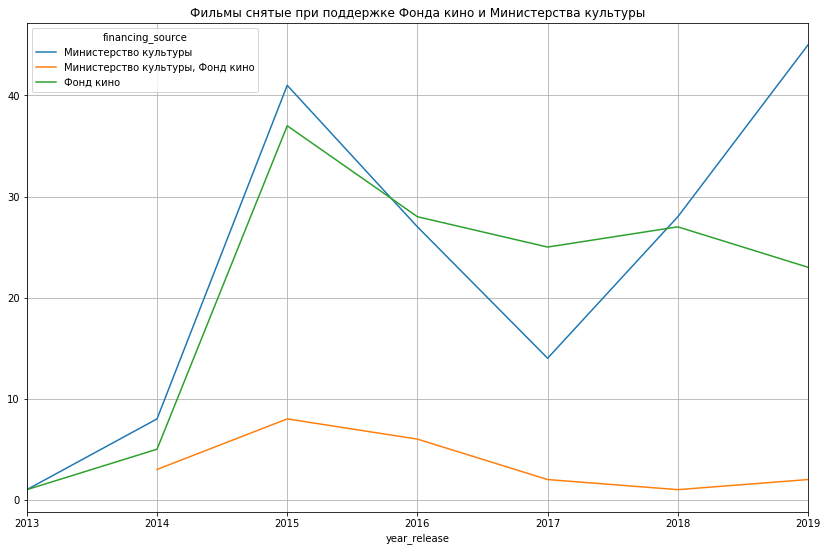

In [117]:
# изучим какую часть фильмов финансирует Фонд кино, а какую Министерство культуры
display(df_gov_sup.pivot_table(index='financing_source',columns='year_release',values='title',aggfunc='count'))
display(df_gov_sup.pivot_table(index='year_release',columns='financing_source',values='title',aggfunc='count').plot(
    grid=True,
    title='Фильмы снятые при поддержке Фонда кино и Министерства культуры',
    figsize=(14,9)
))


Такая тенденция сохраняется и по годам, но в 2017 году Фонд кино финансировал больше фильмов, возможно с этим связано наибольшее количество сборов, аудитория предпочитает игровое кино.

year_release,2013,2014,2015,2016,2017,2018,2019
financing_source,,,,,,,
Министерство культуры,0.365354,10.4971,564.352,844.912,280.144,1971.15,1650.6
"Министерство культуры, Фонд кино",nan,103.085,474.235,129.47,12.671,8.42537,77.451
Фонд кино,19.957,903.84,4746.7,5107.33,10572.3,7954.49,6681.58


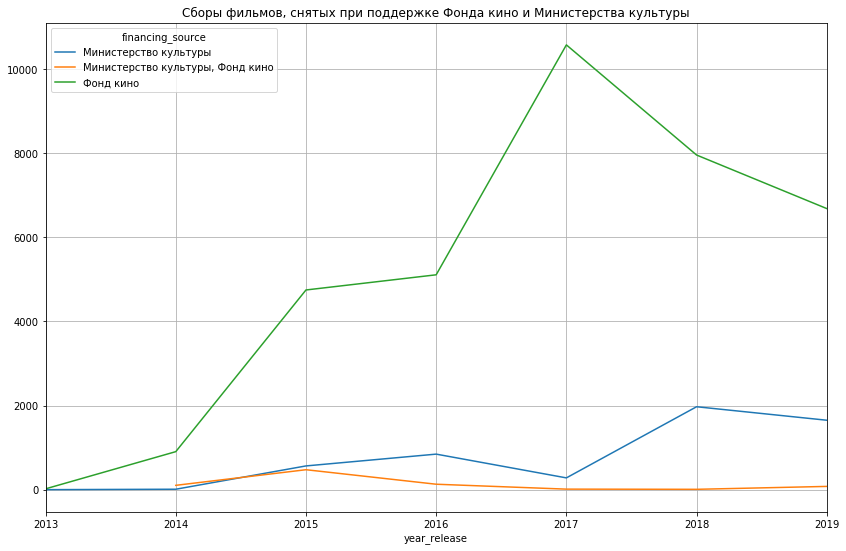

In [118]:
# оценим сборы фильмов
display(df_gov_sup.pivot_table(index='financing_source',columns='year_release',values='box_office_mln',aggfunc='sum')\
.style.highlight_max (color = '#952895'). highlight_min (color = '#F09EF0'))
display(df_gov_sup.pivot_table(index='year_release',columns='financing_source',values='box_office_mln',aggfunc='sum').plot(
    grid=True,
    title='Сборы фильмов, снятых при поддержке Фонда кино и Министерства культуры',
    figsize=(14,9)
))

Судя по сборам, гипотеза о предпочтении аудитории игровых фильмов, подтверждается.

In [119]:
# изучим какие фильмы окупаются в прокате 
# запишем срез в отдельную таблицу
df_gov_sup_payback=df_gov_sup.loc[(df_gov_sup['box_office']>=(df_gov_sup['refundable_support']+df_gov_sup['nonrefundable_support']))&(df_gov_sup['refundable_support']!=0)&(df_gov_sup['nonrefundable_support']!=0)]
# вычислим процент окупаемых фильмов

ratio_payback_film=df_gov_sup_payback['title'].count()/df_gov_sup['title'].count()
print('Процент окупаемых фильмов составляет', ratio_payback_film*100,'%')


Процент окупаемых фильмов составляет 16.867469879518072 %


In [120]:
df_gov_sup_payback.loc[df_gov_sup_payback['main_genre']!='nan'].pivot_table(index='main_genre',values='box_office_mln',aggfunc='sum')\
.style.highlight_max (color = '#952895'). highlight_min (color = '#F09EF0')

,box_office_mln
main_genre,
боевик,196.572
детектив,72.5783
драма,4894.88
история,1308.11
комедия,8439.94
криминал,228.578
мультфильм,2205.34
приключения,877.929
семейный,153.47


Как видно из таблицы, комедии лидируют, меньше всего прибыли приносят детективы и семейные фильмы.

In [121]:
# изучим рейтинг фильмов и его связь с жанром, здесь можно воспользоваться сначала основной таблице, а затем данными
# из таблицы со сведениями о гос поддержке и проследить тенденцию
df_ratings_genre=df.loc[(df['main_genre']!='nan')&(df['ratings']!=0)].pivot_table(index='main_genre',values='ratings',aggfunc=['mean','count'])
df_ratings_genre.columns=['mean_ratings','count_ratings']
df_ratings_genre.sort_values(by='count_ratings',ascending=False).style.highlight_max (color = '#952895'). highlight_min (color = '#F09EF0')

,mean_ratings,count_ratings
main_genre,,
драма,6.76762,1686
комедия,5.98606,696
боевик,6.50891,617
ужасы,5.65864,573
мультфильм,6.27757,535
триллер,6.58964,521
фантастика,6.64317,410
мелодрама,6.52298,383
фэнтези,6.59022,358


Вряд ли можно объективно считать, что самый высокий рейтинг у фильмов в жанре фильм-нуар, т. к. имеется рейтинг только одного фильма, правильно будет взять рейтинги тех фильмов, которых в таблице больше 200

In [122]:
df_ratings_genre.columns=['mean_ratings','count_ratings']
df_ratings_genre.query('mean_ratings>6.6 & count_ratings>200')


,mean_ratings,count_ratings
main_genre,,
документальный,7.237900,219
драма,6.767616,1686
фантастика,6.643171,410


Исходя из количества фильмов и среднего рейтинга лидируют документальные фильмы, драмы и фантастика.

Проверим, сохраняется ли тенденция для фильмов с государственной поддержкой.

In [123]:
df_gov_sup_ratings_genre=df_gov_sup.loc[(df_gov_sup['main_genre']!='nan')&(df_gov_sup['ratings']!=0)].pivot_table(index='main_genre',values='ratings',aggfunc=['mean','count'])
df_gov_sup_ratings_genre.columns=['mean_ratings','count_ratings']
df_gov_sup_ratings_genre.sort_values(by='count_ratings',ascending=False).style.highlight_max (color = '#952895'). highlight_min (color = '#F09EF0')

,mean_ratings,count_ratings
main_genre,,
драма,6.41935,93
комедия,5.51486,74
мультфильм,5.8,31
триллер,5.70667,15
мелодрама,5.95333,15
фантастика,6.14545,11
фэнтези,6.09091,11
ужасы,5.2,10
военный,6.46667,9


Как видно относительно высокий рейтинг драм и фантастики сохраняется и для фильмов с государственной поддержкой.

In [124]:
# проверим тенценцию для окупаемых фильмов
df_gov_sup_payback_ratings_genre=df_gov_sup_payback.loc[(df_gov_sup_payback['main_genre']!='nan')&(df_gov_sup_payback['ratings']!=0)].pivot_table(index='main_genre',values='ratings',aggfunc=['mean','count'])
df_gov_sup_payback_ratings_genre.columns=['mean_ratings','count_ratings']
df_gov_sup_payback_ratings_genre.sort_values(by='count_ratings',ascending=False).style.highlight_max (color = '#952895'). highlight_min (color = '#F09EF0')

,mean_ratings,count_ratings
main_genre,,
комедия,5.76471,17
мультфильм,5.775,12
драма,6.52857,7
ужасы,4.725,4
фэнтези,6.73333,3
история,6.2,2
приключения,6.65,2
семейный,4.4,2
фантастика,3.95,2


Среди окупаемых фильмов, драмы сохраняют высокий рейтинг, но большую часть прибыли приносят комедии (как видно из предыдущих таблиц) но рейтинг комедий не очень высок.

### Шаг 5. Напишем общий вывод

После изучения предложенного датафрейма можно сделать следующие выводы:

1) С 2017 года наметилась положительная динамика производства фильмов (чтобы утверждать это достоверно, нужно изучить и даные за последние 2 года, т. к. в условиях пандемии производство фильмов вероятнее всего сократилось)

2) В 2017 году было снято меньше фильмов, чем в другие годы, но большинство комедийного жанра (приносящего наибольшую прибыль), возможно этим можно объяснить то, что сборы в 2017 году превысилы сборы в остальные годы.

3) Фильмы категории 0+ приносят меньше всего прибыли в прокате, этим можно объяснить небольшое количество фильмов и мультфильмов для детей, производители принимают во внимание их коммерческую невыгодость, возможно поэтому финансированием таких проектов занимается не Фонд кино, а Министерство культуры.

4) Игоровое кино приносит большую прибыть, чем остальное, однако если говорить об окупаемости, то окупается всего около 16% фильмов, снятых с государственной поддержкой.

5) Относительно высокий рейтинг у фильмов в жанре драма, однако большие сборы делают комедии ,рейтинг которых невысок, этим можно объяснить сравнительно большое количество выходящих в прокат комедий невысокого качества, зато коммерчески прибыльных.